# Lecture 10

## The QUAD method


Click here for an interactive version of this notebook:-
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/pjohno/MATH60082/master?labpath=notebooks%2FMATH60082%20-%20Lecture%2010%20Quad%20Method.ipynb)

Consider the well-known Black and Scholes (1973) partial differential equation for an option with an underlying
asset following geometric Brownian motion:
$$
\frac{\partial{V}}{\partial{t}} + \frac{1}{2} {\sigma}^2 S^2
\frac{\partial {^2V}}{\partial{S^2}} + (r-D_c) S
\frac{\partial{V}}{\partial{S}} - rV = 0,
$$
where $V(S,t)$ is the price of the derivative product, $S$ the
current value of the underlying asset, $t$ is time,  $T$ is the time to maturity
 $r$ the risk-free interest rate, $\sigma$ the
volatility of the underlying asset and $X$ is the exercise price of the option. 
$D_c$ is a continuous dividend yield which could, for example, be the foreign 
interest rate in a foreign exchange option.

Next make the following standard
transformations                
$$
x = log(S_0),
$$
$$
y = log(S_{T}).
$$
The final conditions for a European option expiring at time $T$
with  $V(y,T)$ are transformed in straightforward fashion; e.g. 
the payoff for a call option $V(S,T)  = \max(S_{T}-X,0)$ becomes
$$
\quad V(y,T) = \max(e^y-X,0). 
$$
The value of 
the option at time $t=0$ on an underlying asset  $S_0$  
has an  exact solution given by 
$$
V(x,0) = A (x) \int_{-\infty}^{\infty} B(x,y)V(y,T) \, dy,
$$
where, 
$$
A(x) = \frac{1}{\sqrt{2\sigma^2\pi T}} e^{-\frac12 kx-\frac18 
\sigma^2k^2 T - r T},
$$
and
$$
B(x,y) = e^{-\frac{(x-y)^2}{2\sigma^2 T} + \frac12 ky}
$$
and
$$
k = \frac{2(r-D_c)}{{\sigma}^2} -1.
$$

Let us go through an example solving this for a simple call option, before moving onto a barrier option. We will need to declare the functions $A$, $B$, a method for integrating and a method to return the value $V(x,0)$. Since integrations must work on fixed spaced grids, we also provide a function to do this. First include libraries:

In [1]:
// load libraries
#include "math60082_lab_plot_loader.hpp"

IncrementalExecutor::executeFunction: symbol '_ZN5boost6system16generic_categoryEv' unresolved while linking function '__cxx_global_var_initcling_module_5_.16'!
You are probably missing the definition of boost::system::generic_category()
Maybe you need to load the corresponding shared library?
IncrementalExecutor::executeFunction: symbol '_ZN5boost6system15system_categoryEv' unresolved while linking function '__cxx_global_var_initcling_module_5_.16'!
You are probably missing the definition of boost::system::system_category()
Maybe you need to load the corresponding shared library?


In [2]:
// include standard stuff
#include <iostream>
#include <cmath>
#include <fstream>
#include <sstream>
#include <vector>
#include <algorithm>
#include <functional>

// project specific stuff
#include <math60082_markupTable.hpp>
using namespace MATH60082;

Numerically we also will have to bound the intergration, so we need a way to input these values. In fact the integration will look like
$$
V(x,0) = A (x) \int_\text{yMin}^\text{yMax} B(x,y)V(y,T) \, dy \approx A(x) \sum_j w_j B(x,y_j)V(y_j,T),
$$
where $w_j$ depends on the numerical integration scheme we choose.
By using this approximation we are assuming that the payoff is zero for $y<\text{yMin}$ and $y>\text{yMax}$, so in some cases the approximation can be improved here by using analytic results for the integrals either side
$$
V_\text{min}(x,0) = A (x) \int_{-\infty}^\text{yMin} B(x,y)V(y,T) \, dy,
$$
and
$$
V_\text{max}(x,0) = A (x) \int_\text{yMax}^\infty B(x,y)V(y,T) \, dy,
$$
such that
$$
V(x,0) = V_\text{min} + A (x) \int_\text{yMin}^\text{yMax} B(x,y)V(y,T) \, dy + V_\text{max},
$$


Input the function $A$ as given by the formula:

In [3]:
// the function A
double A(double x, double r, double sigma, double k, double dt)
{
    return 1. / sqrt(2 * sigma*sigma*M_PI*dt) * exp(-0.5*k*x - 0.125*sigma*sigma*k*k*dt - r*dt);
}

Input the function $B$ as given by the formula:

In [4]:
// the function B
double B(double x, double y, double sigma, double k, double dt)
{
    return exp(-(x - y)*(x - y) / (2.*sigma*sigma*dt) + 0.5 * k * y);
}

Here we include a simple method for integrating a function according to the Simpsons rule. It assumes that n is even. 

In [5]:
// integration proceedure: integrate the function f_i at equally spaced points x_i = a + i*h
// n is the number of intervals
// a is the lower bound
// b is the upper bound
// f is a vector containing the values f(x_i = a + i*h)
double integrate(int n,double a,double b,const std::vector<double> &f)
{
    double sum, h = (b - a) / n;
    sum = f[0];
    for (int i = 2; i<n; i+=2)
    {
        sum += 2.*f[i];
    }
    for (int i = 1; i<n; i+=2)
    {
        sum +=  4.*f[i];
    }
    sum += f[n];
    return h / 3.*sum;
}

Resetting the grid over an interval:

In [6]:
// create grid with n+1 nodes, equally spaced on the range [a,b]
void createGrid(int n, double a, double b, std::vector<double> &x)
{
    x.resize(n + 1);
    double h = (b - a) / double(n);
    if (n == 0)h = 0.;
    for (unsigned int i = 0; i<x.size(); i++) x[i] = a + i*h;
}

# Example - Call Option

We first set up the grid over the interval by applying a log transform
$$
x = log(S_0)
$$
and for the $y$ variable at $T$ for a call option we use
$$
y \in [ log(X) , log (X) + \xi \sigma T ] ,
$$
where $\xi$ is some grid scale factor set large enough to capture the value of the option.
After the variable $k$ is assigned, we can generate values of the integrand, $f_j$
$$
f_j = B(x,y_j) V(y_j,T) = B(x,y_j) (e^{y_j} -X)
$$
for our call option.

Then the value of the option can be found as
$$
V(x,0) = A(x) \frac{\text{yMax}-\text{yMin}}{3 n}\left( f_0 + 2\sum f_{2j} + 4\sum f_{2j+1}+ f_n \right)
$$

In [7]:
{
    double  S0 = 97.7402, X = 100., r = 0.06, Dc = 0.02, sigma = 0.2, T = 1.;
    
    int N=500;
    
    double xi=10.;
    
    // now get value of x at time t=0
    double x = log(S0);
    
    // store values for the grid 
    std::vector<double> y(N+1);
    
    // set y grid up at the final step, using strike price as lower limit
    createGrid(N,log(X),log(X)+ 10*sigma*sqrt(T),y);
    
    // variable k
    double k = 2.*(r - Dc) / sigma / sigma - 1.;
           
    // setup vectors to store option values, and integrand function
    // these vectors must be the same size as the y vector
    std::vector<double> f(N+1);
    
    for (uint j = 0; j < y.size(); j++)
    {
        f[j] = B( x , y[j] , sigma , k , T ) * (exp(y[j]) - X);
    }
    // now do the integral
    double value = A(x, r, sigma, k, T )*integrate(N, y[0],y[N], f);;
    std::cout << "C("<<S0<<") = " << value << "\n"; 
}   

C(97.7402) = 8.40841


Now put this in a function so that we can investigate the convergence

In [8]:
double callOption(double  S0,double X,double r,double Dc,double sigma,double T,int N,double xi)
{
    // now get value of x at time t=0
    double x = log(S0);
    
    // store values for the grid 
    std::vector<double> y(N+1);
    
    // set y grid up at the final step, using strike price as lower limit
    createGrid(N,log(X),log(X)+ 10*sigma*sqrt(T),y);
    
    // variable k
    double k = 2.*(r-Dc) / sigma / sigma - 1.;
           
    // setup vectors to store option values, and integrand function
    // these vectors must be the same size as the y vector
    std::vector<double> f(N+1);
    
    for (uint j = 0; j < y.size(); j++)
    {
        f[j] = B( x , y[j] , sigma , k , T ) * (exp(y[j]) - X);
    }
    // now do the integral
    return A(x, r, sigma, k, T )*integrate(N, y[0],y[N], f);
}

In [9]:
{
    double  S0 = 97.7402, X = 100., r = 0.06, Dc = 0.02, sigma = 0.2, T = 1.;
    
    int N=500;
    
    std::cout << " Examine convergence of a call option using QUAD...\n\n";
    tableRow("N","V(S,0;N)","R","conv rate");
    emptyTableRow(4);
    double valueOld = 1.,diffOld=1.;
    int k=2;
    for(int n=10;n<=5000;n*=k)
    {
        double value = callOption(S0,X,r,Dc,sigma,T,n,10.);
        double diff = value - valueOld;
        double R = diffOld/diff;
        tableRow( n ,value ,R ,log(R)/log(k));
        valueOld = value;
        diffOld = diff;
    }
}

 Examine convergence of a call option using QUAD...

|             N|      V(S,0;N)|             R|     conv rate|
|--------------|--------------|--------------|--------------|
|            10|       8.69934|      0.129881|      -2.94473|
|            20|       8.41757|      -27.3249|          -nan|
|            40|       8.40891|       32.5561|       5.02486|
|            80|       8.40844|       18.3338|       4.19643|
|           160|       8.40841|       16.4873|       4.04329|
|           320|       8.40841|       16.1173|       4.01054|
|           640|       8.40841|       16.0291|       4.00262|
|          1280|       8.40841|       16.0073|       4.00065|
|          2560|       8.40841|       16.0023|       4.00021|


Now we can see the power of this method, since we use integration and the simpsons rule we are able to get 4th order convergence,
$$
V^N = V^\text{exact} + O\left(N^{-4}\right) ,
$$
and we could get even higher convergence by extrapolating these results!

## Example -- Up and Out Barrier Call Option

This is nice but we already have an analytic solution to this problem. How about something more complicated? The discretely observed up-and-out barrier call option is a problem that can't easily be solved with standard techniques such as Monte-Carlo or Lattice methods. However this problem is uniquely adaptable to quadrature methods, given that  we know at each observation time point $t_k$ the value of the function becomes zero, the region over which this happens can be split out and set to zero.

To see how to solve this method using quadrature, the best way is to first observe how the grid adapts to the problem through time. Consider an up and out barrier call option observed at equally spaced times $t_k=k\Delta t$ such that $$\Delta t = \frac{T}{K}.$$ The payoff for the option is given by
$$
V(S,T) = \max(S-X,0)
$$
and the condition at each observation point is that
$$
V(S,t_k) = 0 \text{ if } S>B \text{ for } k=0,1,\dots K-1 .
$$
At the terminal time, as before apply a log transform so that the $y$ variable at $T$ becomes
$$
y \in [ log(X) ,  log (X) + \xi \sigma T ] .
$$

Now for the $x$ grid, this is set at $t=t_{K-1}$, and we use the fact that $V$ is zero above the barrier to ignore any point above $S>B$, therefore
$$
x \in [  log(S_0) - \xi \sigma sqrt(T) , log(B) ] .
$$

The lower boundary here is calculated to be sufficiently small such that $B( log(S_0), y_\text{min} , t_k )V(y_\text{min},t_k) = 0 $ for $y<y_\text{min}$.

The grids follow this pattern through time until we arrive at the last step, at which point we will wish to calculate $x_0 =  log(S_0)$.

In [10]:
{
    // open up a file stream to write data
    ofstream output;
    // here we are going to use comma separated variables, so end the filename with .csv

    // I'm outputing to current working directory
    output.open("test-1.dat");

    if(!output.is_open())
    {
        // NOTE!!!! The file will not open unless the directory exists!!!
        cout << " File not opened \n";
        // stop the program here
        throw;
    }
    // plot out the grid for an up and out barrier call
    
    // setup some dummy parameters
    double  S0 = 97.7402, X = 100., r = 0.06, Dc = 0.02, sigma = 0.2, T = 1.;

    // K is the number of observations
    int K=5;

    // B is the barrier
    double B=110.;
    
    // N is the number of nodes at each step
    int N=4;
    // grid scale
    double xi=1.;
    
    // first setup a time grid
    std::vector<double> t(K+1);
    createGrid(K,0.,T,t);
    
    // store values for the grid 
    std::vector<double> y(N+1);
    // set y grid up at t=T, using strike price as lower limit
    // here we use xi=1 to make the picture look nicer
    createGrid(N,log(X),log(X)+ xi*sigma*sqrt(t[K]),y);

    // store values for the grid 
    std::vector<double> x(N+1);
    // and the x grid at t=t_{K-1}, now using the barrier as the upper limit and S0 at the lower limit
    createGrid(N,log(S0)-xi*sigma*sqrt(t[K-1]),log(B),x);

    for(int i=0;i<=N;i++)
    {
        for(int j=0;j<=N;j++)
        {
            output << t[K-1] << " " << exp(x[i]) << endl;
            output << t[K] << " " << exp(y[j]) << endl;
            output << endl << endl;
        }
    }
    
    // overwrite the y values with x
    y = x;
    
    // now move back through time
    for(int k=K-2;k>0;k--)
    {
        // and the x grid at t=t_{k}, now using the barrier as the upper limit and S0 at the lower limit
        createGrid(N,log(S0)-xi*sigma*sqrt(t[k]),log(B),x);

        for(int i=0;i<=N;i++)
        {
            for(int j=0;j<=N;j++)
            {
                    output << t[k] << " " << exp(x[i]) << endl;
                    output << t[k+1] << " " << exp(y[j]) << endl;
                    output << endl << endl;
            }
        }

        // overwrite the y values with x
        y = x;
        
    }
    
    // and at the final step, x = x0 at t=t_{0}, 
    createGrid(0,log(S0),log(S0),x);
    for(int j=0;j<=N;j++)
    {
            output << t[0] << " " << exp(x[0]) << endl;
            output << t[1] << " " << exp(y[j]) << endl;
            output << endl << endl;
    }
    
    // file write successful then close file
    cout << " File write successful \n";
    output.close();
}

 File write successful 


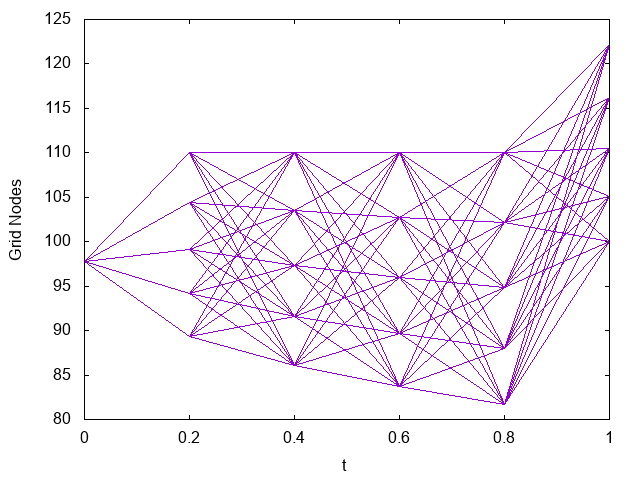

In [11]:
MATH60082::gnuplotImage fig1;
{
    std::stringstream ss;
    ss << "set xlabel 't'" << endl;
    ss << "set ylabel 'Grid Nodes'" << endl;
    ss << "unset key"<< endl;
    ss << "p'test-1.dat' u 1:2 w l";
    fig1 = MATH60082::GnuplotWidget::plotCommand(&ss);
    
}
fig1

Now all that need to be done compared to the code above, is to put in `vNew` and `vOld` to calculate the option values at each timestep as we would do with an explicit method.

In [12]:
double barrierCallOption(// Black Scholes parameters
    double S0,double X,double r,double Dc,double sigma,double T ,
    // K is the number of observations
    int K,
    // Barrier is the barrier
    double Barrier,
    // N is the number of nodes at each step
    int N,
    // grid scale
    double xi
    )
    {
        
    // first setup a time grid
    std::vector<double> t(K+1);
    createGrid(K,0.,T,t);
    
    // store values for the grid 
    std::vector<double> y(N+1);
    // set y grid up at t=T, using strike price as lower limit
    // here we use xi=1 to make the picture look nicer
    createGrid(N,log(X),log(X)+ xi*sigma*sqrt(t[K]),y);

    // store values for the grid 
    std::vector<double> x(N+1);
    // and the x grid at t=t_{K-1}, now using the barrier as the upper limit and S0 at the lower limit
    createGrid(N,log(S0)-xi*sigma*sqrt(t[K-1]),log(Barrier),x);

    // store values for the option 
    std::vector<double> vNew(N+1),vOld(N+1);
    
    for(int j=0;j<=N;j++)
    {
        vOld[j] = exp(y[j]) - X;            
    }
    
    // calculate the option values at x_i
    for(int i=0;i<=N;i++)
    {
        // variable k
        double kStar = 2.*(r-Dc) / sigma / sigma - 1.;

        // setup vectors to store option values, and integrand function
        // these vectors must be the same size as the y vector
        std::vector<double> f(N+1);

        for (uint j = 0; j < y.size(); j++)
        {
            f[j] = B( x[i] , y[j] , sigma , kStar , t[K]-t[K-1] ) * vOld[j];
        }
        // now do the integral
        vNew[i] = A(x[i], r, sigma, kStar, t[K]-t[K-1] )*integrate(N, y[0],y[N], f);          
    }
    // overwrite the y values with x
    y = x;
    vOld = vNew;
    
    // now move back through time
    for(int k=K-2;k>0;k--)
    {
        // and the x grid at t=t_{k}, now using the barrier as the upper limit and S0 at the lower limit
        createGrid(N,log(S0)-xi*sigma*sqrt(t[k]),log(Barrier),x);

        for(int i=0;i<=N;i++)
        {
            // variable k
            double kStar = 2.*(r-Dc) / sigma / sigma - 1.;

            // setup vectors to store option values, and integrand function
            // these vectors must be the same size as the y vector
            std::vector<double> f(N+1);

            for (uint j = 0; j < y.size(); j++)
            {
                f[j] = B( x[i] , y[j] , sigma , kStar , t[k+1]-t[k] ) * vOld[j];
            }
            // now do the integral
            vNew[i] = A(x[i], r, sigma, kStar, t[k+1]-t[k] )*integrate(N, y[0],y[N], f);          
        }

        // overwrite the y values with x
        y = x;
        // and old with new
        vOld = vNew;
    }
    
    // and at the final step, x = x0 at t=t_{0}, 
    createGrid(0,log(S0),log(S0),x);
    
    {
            // variable k
            double kStar = 2.*(r-Dc) / sigma / sigma - 1.;

            // setup vectors to store option values, and integrand function
            // these vectors must be the same size as the y vector
            std::vector<double> f(N+1);

            for (uint j = 0; j < y.size(); j++)
            {
                f[j] = B( x[0] , y[j] , sigma , kStar , t[1]-t[0] ) * vOld[j];
            }
            // now do the integral
            return A(x[0], r, sigma, kStar, t[1]-t[0] )*integrate(N, y[0],y[N], f);
    }
}

In [16]:
{
    // setup some dummy parameters
    double  S0 = 97.7402, X = 100., r = 0.06 , Dc = 0.02, sigma = 0.2, T = 1.;

    // K is the number of observations
    int K=5;

    // B is the barrier
    double B=110.;
    
    std::cout << " Examine convergence for the up-and-out Barrier call option using QUAD...\n\n";
    tableRow("N","V(S,0;N)","R","conv rate");
    emptyTableRow(4);
    double valueOld = 1.,diffOld=1.;
    int k=2;
    for(int n=10;n<=5000;n*=k)
    {
        double value = barrierCallOption(S0,X,r,Dc,sigma,T,K,B,n,10.);
        double diff = value - valueOld;
        double R = diffOld/diff;
        tableRow( n ,value ,R ,log(R)/log(k));
        valueOld = value;
        diffOld = diff;
    }
    
    
}

 Examine convergence for the up-and-out Barrier call option using QUAD...

|             N|      V(S,0;N)|             R|     conv rate|
|--------------|--------------|--------------|--------------|
|            10|      0.784989|      -4.65092|          -nan|
|            20|       1.32482|     -0.398296|          -nan|
|            40|       1.28818|      -14.7342|          -nan|
|            80|       1.28697|       30.2467|        4.9187|
|           160|        1.2869|       17.4078|       4.12167|
|           320|       1.28689|        16.321|       4.02866|
|           640|       1.28689|       16.0781|       4.00703|
|          1280|       1.28689|       16.0194|       4.00175|
|          2560|       1.28689|       16.0048|       4.00044|


Again using integration and the simpsons rule, we are able to get 4th order convergence,
$$
V^N = V^\text{exact} + O\left(N^{-4}\right) .
$$
This is because we avoid any errors that arise from discontinuities in the payoff by splitting the integral. The method is tricky to setup and harder to generalise than other methods, but it is extremely powerful none the less.